[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/SyntheticRubber.ipynb)

In [1]:
# !pip install yfinance

In [2]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import os

In [3]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками.
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отдельном файле

### 1. Проанализируем имеющиеся данные

In [4]:
# Из данных есть:

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [5]:
# Скачаем котировки натурального каучука с сайта Малайзийской Rubber Board https://www.lgm.gov.my

year = '2022'
month = '06'
url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
res = requests.get(url)
rj = res.json()
df = pd.json_normalize(rj)
df.head(10)

,date,grade,masa,rm,us,tone
0,2022-06-30,SMR CV,Noon,979.00,226.10,Quietly Steady
1,2022-06-30,SMR L,Noon,969.00,223.80,Quietly Steady
2,2022-06-30,SMR 5,Noon,719.00,166.05,Quietly Steady
3,2022-06-30,SMR GP,Noon,716.00,165.40,Quietly Steady
4,2022-06-30,SMR 10,Noon,709.00,163.75,Quietly Steady
5,2022-06-30,SMR 20,Noon,707.00,163.30,Quietly Steady
6,2022-06-30,Latex in Bulk,Noon,575.50,575.50,Quietly Steady
7,2022-06-29,SMR CV,Noon,989.00,228.65,Quietly Steady
8,2022-06-29,SMR L,Noon,979.00,226.35,Quietly Steady
9,2022-06-29,SMR 5,Noon,714.00,165.10,Quietly Steady


### 2. Определим базовую формулу цены на условиях FCA (цена на заводе), т.е. как бы выглядела цена на исторических данных

Определим базовую формулу для расчёта цены на заводе:

PRICE_CINT = (PRICE_SMR_20 * EXCHANGE_RATE) * 2 + PRODUCTION_COST, где 

- PRICE_CINT - цена синтетического каучука на условии FCA (цена на заводе)
- PRICE_SMR_20 - цена на натуральный каучук SMR на Малайзийской Rubber Board, рассчитываемая как среднеарифметическая величина за месяц, предшествующий месяцу поставки
- EXCHANGE_RATE - среднее значение курса доллара/евро за месяц, предшествующий месяцу поставки
- 2 - Ставка НДС, равна 20%
- PRODUCTION_COST - затраты на производство

**Узнаем цену на натуральный каучук с грейдом SMR 20** *(показатель в формуле PRICE_SMR_20)*

В полученной таблице с котировками натурального каучука приведём столбцы с датой и ценами к нужным нам типам данных:

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['rm'] = df['rm'].astype(float)
df['us'] = df['us'].astype(float)

# проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    147 non-null    datetime64[ns]
 1   grade   147 non-null    object        
 2   masa    147 non-null    object        
 3   rm      147 non-null    float64       
 4   us      147 non-null    float64       
 5   tone    147 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 7.0+ KB


Посмотрим, за какой период цены в выгруженной таблице

In [7]:
df['date'].describe(datetime_is_numeric=True)

count                              147
mean     2022-06-16 03:25:42.857142784
min                2022-06-01 00:00:00
25%                2022-06-09 00:00:00
50%                2022-06-16 00:00:00
75%                2022-06-23 00:00:00
max                2022-06-30 00:00:00
Name: date, dtype: object

Цены за июнь, т.е. за месяц, предшествующий предыдущему.

Синтетический каучук будет заменой натуральному с грейдом SMR 20, сформируем датафрэйм только с данными по нему:

In [8]:
df_smr_20 = df[df['grade'] == 'SMR 20']
df_smr_20.head()

,date,grade,masa,rm,us,tone
5,2022-06-30,SMR 20,Noon,707.0,163.30,Quietly Steady
12,2022-06-29,SMR 20,Noon,702.0,162.30,Quietly Steady
19,2022-06-28,SMR 20,Noon,699.0,161.55,Quiet
26,2022-06-27,SMR 20,Noon,707.0,163.40,Quietly Steady
33,2022-06-24,SMR 20,Noon,704.0,162.60,Quietly Steady


Переместим даты в индекс и рассчитаем среднемесячную цену в долларах к последней дате:

In [9]:
df_smr_20.set_index('date', inplace=True)

mes = round(df_smr_20[['us']].resample('M').mean(), 2)
mes

,us
date,
2022-06-30,164.15


Мы получили среднемесячную цену в us за килограмм, сохраним в отдельную переменную:

In [10]:
PRICE_SMR_20 = mes.iloc[0]['us']
PRICE_SMR_20

164.15

**Скачаем данные о ценах на сырую нефть и котировки курсов валют** *(показатель в формуле EXCHANGE_RATE)*

In [11]:
# используем библиотеку yf, сформируем словарь

df_dict = {}
for ticker in tqdm(['CL=F','USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
    df = yf.download(ticker)
    df = df.Close.copy()
    df = df.resample('M').mean()
    df_dict[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Соединим полученные данные в датафрэйм:

In [12]:
main_df = pd.concat(df_dict.values(), axis=1)
main_df.columns = ['CRUDE_OIL_USD','USDRUB', 'EURUSD', 'EURRUB']

Ограничим данные последними 4 годами:

In [13]:
main_df = main_df.loc['2019-06-30':'2022-06-30'].copy()
main_df.head()

,CRUDE_OIL_USD,USDRUB,EURUSD,EURRUB
Date,,,,
2019-06-30,54.706500,64.168690,1.129002,72.458005
2019-07-31,57.546364,63.176222,1.122682,70.956822
2019-08-31,54.844091,65.687992,1.113163,73.143709
2019-09-30,56.967000,64.971148,1.101377,71.589861
2019-10-31,54.005653,64.341009,1.104839,71.093322


Затраты на производство нам известны

In [14]:
PRODUCTION_COST = 400 # (EUR)

Мы получили цену за килограмм натурального каучука, цену сырой нефти и котировки валют друг к другу, а также мы знаем затраты на само производство. Это поможет нам в  рассчитать формулу цены синтетического каучука в долларах и евро

Вспомним формулу FCA (цена на заводе):

PRICE_CINT = (PRICE_SMR_20 * EXCHANGE_RATE) * 2 + PRODUCTION_COST

In [15]:
main_df['MWP_PRICE_EUR'] = (PRICE_SMR_20 * (1/main_df['EURUSD'])) * 2 + PRODUCTION_COST
main_df['MWP_PRICE_USD'] = (PRICE_SMR_20 * main_df['EURUSD']) * 2 + PRODUCTION_COST * main_df['EURUSD']

main_df.head()

,CRUDE_OIL_USD,USDRUB,EURUSD,EURRUB,MWP_PRICE_EUR,MWP_PRICE_USD
Date,,,,,,
2019-06-30,54.706500,64.168690,1.129002,72.458005,690.787803,822.252130
2019-07-31,57.546364,63.176222,1.122682,70.956822,692.424839,817.649045
2019-08-31,54.844091,65.687992,1.113163,73.143709,694.925304,810.716771
2019-09-30,56.967000,64.971148,1.101377,71.589861,698.081407,802.132856
2019-10-31,54.005653,64.341009,1.104839,71.093322,697.147281,804.654477


### 3. Отобразим цены на графике

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,5

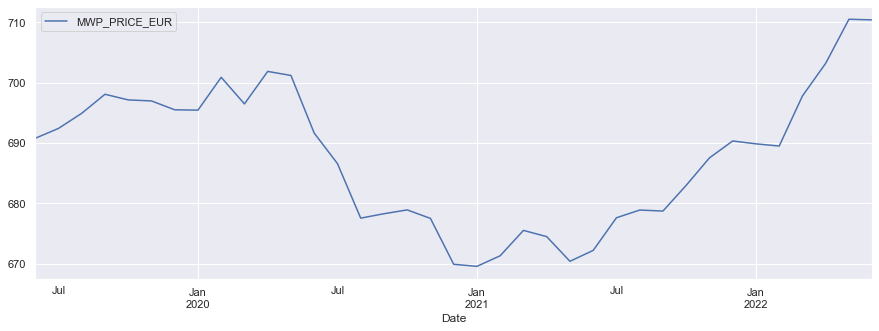

In [17]:
# График с базовой ценой FCA (на заводе) в евро

main_df['MWP_PRICE_EUR'].plot()
plt.legend();

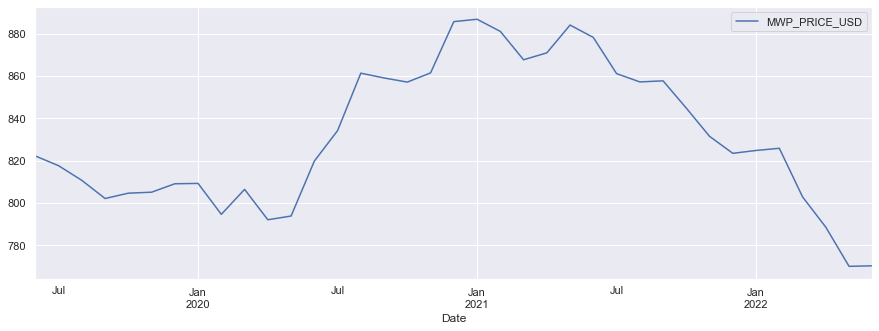

In [18]:
# График с базовой ценой FCA (на заводе) в долларах 

main_df['MWP_PRICE_USD'].plot()
plt.legend();

### 4. Сделаем расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой)
Запишем в один excel-файл на разных листах. Каждый лист - название клиента.

Расходы на логистику нам известны

In [19]:
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

Добавим к цене FCA (цена на заводе) затраты на логистику с учётом территории клиента:

In [20]:
main_df['MWP_PRICE_EUR_EU'] = main_df['MWP_PRICE_EUR'] + EU_LOGISTIC_COST_EUR
main_df['MWP_PRICE_USD_CN'] = main_df['MWP_PRICE_USD'] + CN_LOGISTIC_COST_USD

main_df.head()

,CRUDE_OIL_USD,USDRUB,EURUSD,EURRUB,MWP_PRICE_EUR,MWP_PRICE_USD,MWP_PRICE_EUR_EU,MWP_PRICE_USD_CN
Date,,,,,,,,
2019-06-30,54.706500,64.168690,1.129002,72.458005,690.787803,822.252130,720.787803,952.252130
2019-07-31,57.546364,63.176222,1.122682,70.956822,692.424839,817.649045,722.424839,947.649045
2019-08-31,54.844091,65.687992,1.113163,73.143709,694.925304,810.716771,724.925304,940.716771
2019-09-30,56.967000,64.971148,1.101377,71.589861,698.081407,802.132856,728.081407,932.132856
2019-10-31,54.005653,64.341009,1.104839,71.093322,697.147281,804.654477,727.147281,934.654477


Добавим столбец с со средними ценами за три месяца:

In [21]:
main_df['MWP_PRICE_EUR_EU_MA'] = main_df['MWP_PRICE_EUR_EU'].rolling(window=3).mean()
main_df['MWP_PRICE_USD_CN_MA'] = main_df['MWP_PRICE_USD_CN'].rolling(window=3).mean()

main_df.tail()

,CRUDE_OIL_USD,USDRUB,EURUSD,EURRUB,MWP_PRICE_EUR,MWP_PRICE_USD,MWP_PRICE_EUR_EU,MWP_PRICE_USD_CN,MWP_PRICE_EUR_EU_MA,MWP_PRICE_USD_CN_MA
Date,,,,,,,,,,
2022-02-28,91.628947,77.466339,1.133995,87.878880,689.507324,825.888916,719.507324,955.888916,719.908096,954.748355
2022-03-31,108.262174,111.013403,1.102412,132.952291,697.801413,802.887023,727.801413,932.887023,722.393161,947.876469
2022-04-30,101.640499,80.666187,1.082745,86.109895,703.210960,788.562821,733.210960,918.562821,726.839899,935.779587
2022-05-31,109.259523,65.422944,1.057322,68.104363,710.501319,770.047903,740.501319,900.047903,733.837898,917.165916
2022-06-30,114.154091,60.146091,1.057670,60.378959,710.399407,770.300731,740.399407,900.300731,738.037229,906.303818


Сделаем расчет возможной цены по формуле для каждого из клиентов с учётом объёмов их поставок, пожелания к расчёту цены, а также скидок

Вспомним, кто наши клиенты:

In [22]:
customers

{'Monty': {'location': 'EU', 'volumes': 200, 'comment': 'moving_average'},
 'Triangle': {'location': 'CN', 'volumes': 30, 'comment': 'monthly'},
 'Stone': {'location': 'EU', 'volumes': 150, 'comment': 'moving_average'},
 'Poly': {'location': 'EU', 'volumes': 70, 'comment': 'monthly'}}

Какие есть скидки в зависимости от объёма покупки:

In [23]:
discounts

{'up to 100': 0.01, 'up to 300': 0.05, '300 plus': 0.1}

Переименуем ключи словаря для удобства

In [24]:
discounts = {100: 0.01, 300: 0.05, 301: 0.1}
discounts

{100: 0.01, 300: 0.05, 301: 0.1}

Рассчитаем формулу с учётом локации, объёма и скидки:

In [25]:
with pd.ExcelWriter('price_proposals_all.xlsx', engine = 'xlsxwriter') as writer:

    for client, v in customers.items():
        disc = 0.0                                 # переменная для скидки
        if v.get('location') == "EU":
            fl = 0                                 # флаг для определения максимальной скидки
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))            

            if v.get('comment') == "moving_average":
                price = round(main_df['MWP_PRICE_EUR_EU_MA'] - main_df['MWP_PRICE_EUR_EU_MA'] * disc, 0)
                print('Клиент:', client)
                print('Скидка:', disc, '%')
                print('Цена:', price[-1], 'euro')
                print('')
            elif v.get('comment') == "monthly":
                price = round(main_df['MWP_PRICE_EUR_EU'] - main_df['MWP_PRICE_EUR_EU'] * disc, 0)            
                print('Клиент:', client)
                print('Скидка:', disc, '%')
                print('Цена:', price[-1], 'euro')
                print('')
       
        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))                    
                    
            if v.get('comment') == "moving_average":
                price = round(main_df['MWP_PRICE_USD_CN_MA'] - main_df['MWP_PRICE_USD_CN_MA'] * disc, 0)
                print('Клиент:', client)
                print('Скидка:', disc, '%')
                print('Цена:', price[-1], 'dollar')
                print('')  
            elif v.get('comment') == "monthly":
                price = round(main_df['MWP_PRICE_USD_CN'] - main_df['MWP_PRICE_USD_CN'] * disc, 0) 
                print('Клиент:', client)
                print('Скидка:', disc, '%')
                print('Цена:', price[-1], 'dollar')
                print('')  

        # сохраним информацию в excel-файл, каждого клиента - на отдельном листе
        price.to_excel(writer, sheet_name=client)
        
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена DDP (цена с доставкой)', fontsize=16, fontweight='bold')
        plt.plot(price)
        plt.savefig(plot_path)
        plt.close()
   #     plt.show()
        worksheet = writer.sheets[client]
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

Клиент: Monty
Скидка: 0.05 %
Цена: 701.0 euro

Клиент: Triangle
Скидка: 0.01 %
Цена: 891.0 dollar

Клиент: Stone
Скидка: 0.05 %
Цена: 701.0 euro

Клиент: Poly
Скидка: 0.01 %
Цена: 733.0 euro



### 5. Предложим формулу цены каждому из клиентов на условиях DDP (цена с доставкой)


Итоговая формула:

PRICE_CINT_DDP = (PRICE_CINT + LOGISTIC_COST) * (1 - DISC), где 

- PRICE_CINT - цена синтетического каучука на условии FCA (цена на заводе)
- LOGISTIC_COST - затраты на доставку
- DISC - размер скидки в зависимости от объема закупки

В предыдущем пункте мы рассчитали её отдельно для каждого клиента с учётом комментариев к заказам.

### 6. Создадим директорию «для клиентов» и в неё сложим файлы с расчетами

Создаем директорию для ценовых предложений клиентам

In [26]:
price_proposals_path = 'price_proposals_client'

if not os.path.exists(price_proposals_path):
    os.mkdir(price_proposals_path)

### 7. Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf) с именем клиента

На основе кода из п.4 запишем предложение для каждого клиента в отдельный файл 

In [27]:
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'price_proposals_{client}.xlsx')
    disc = 0.0                                  # переменная для скидки
    if v.get('location') == "EU":
        fl = 0                                 # флаг для определения максимальной скидки
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))            

        if v.get('comment') == "moving_average":
            price = round(main_df['MWP_PRICE_EUR_EU_MA'] - main_df['MWP_PRICE_EUR_EU_MA'] * disc, 0)
            print('Клиент:', client)
            print('Скидка:', disc, '%')
            print('Цена:', price[-1], 'euro')
            print('')
        elif v.get('comment') == "monthly":
            price = round(main_df['MWP_PRICE_EUR_EU'] - main_df['MWP_PRICE_EUR_EU'] * disc, 0)            
            print('Клиент:', client)
            print('Скидка:', disc, '%')
            print('Цена:', price[-1], 'euro')
            print('')
       
    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))                    
                    
        if v.get('comment') == "moving_average":
            price = round(main_df['MWP_PRICE_USD_CN_MA'] - main_df['MWP_PRICE_USD_CN_MA'] * disc, 0)
            print('Клиент:', client)
            print('Скидка:', disc, '%')
            print('Цена:', price[-1], 'dollar')
            print('')  
        elif v.get('comment') == "monthly":
            price = round(main_df['MWP_PRICE_USD_CN'] - main_df['MWP_PRICE_USD_CN'] * disc, 0) 
            print('Клиент:', client)
            print('Скидка:', disc, '%')
            print('Цена:', price[-1], 'dollar')
            print('')             
                
        # сохраним информацию в excel-файл, каждого клиента - на отдельном листе
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        price.to_excel(writer, sheet_name='price_proposal')
        
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена DDP (цена с доставкой)', fontsize=16, fontweight='bold')
        plt.plot(price)
        plt.savefig(plot_path)
        plt.close()
    #    plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)
        
for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

Клиент: Monty
Скидка: 0.05 %
Цена: 701.0 euro

Клиент: Triangle
Скидка: 0.01 %
Цена: 891.0 dollar

Клиент: Stone
Скидка: 0.05 %
Цена: 701.0 euro

Клиент: Poly
Скидка: 0.01 %
Цена: 733.0 euro



# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [28]:
# дублирует п.7

# Задание 3. Back to Russia

К вам пришел новый клиент из России, он готов регулярно закупать синтетический каучук. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a> или из любого другого источника.


Вспомним, какие данные есть в нашем датафрэйме

In [29]:
main_df.head(3)

,CRUDE_OIL_USD,USDRUB,EURUSD,EURRUB,MWP_PRICE_EUR,MWP_PRICE_USD,MWP_PRICE_EUR_EU,MWP_PRICE_USD_CN,MWP_PRICE_EUR_EU_MA,MWP_PRICE_USD_CN_MA
Date,,,,,,,,,,
2019-06-30,54.706500,64.168690,1.129002,72.458005,690.787803,822.252130,720.787803,952.252130,NaN,NaN
2019-07-31,57.546364,63.176222,1.122682,70.956822,692.424839,817.649045,722.424839,947.649045,NaN,NaN
2019-08-31,54.844091,65.687992,1.113163,73.143709,694.925304,810.716771,724.925304,940.716771,722.712648,946.872648


Видим, что у нас есть котировки доллара к рублю. Также у нас есть рассчитанная ранее цена в долларах. Остаётся посчитать цену с учётом курса (переведём в рубли) и без учёта доставки.

In [30]:
disc = discounts.get(max(discounts.keys()))    
main_df['MWP_PRICE_RUB'] = (main_df['MWP_PRICE_USD'] - main_df['MWP_PRICE_USD'] * disc) * main_df['USDRUB']
price = round(main_df['MWP_PRICE_RUB'], 0)
price.head()

Date
2019-06-30    47487.0
2019-07-31    46490.0
2019-08-31    47929.0
2019-09-30    46904.0
2019-10-31    46595.0
Freq: M, Name: MWP_PRICE_RUB, dtype: float64

Сохраним расчёты в файл, а также выведем в файл график изменения цены на ретро-периодах

Клиент: client_RU
Скидка: 0.1 %
Цена: Date
2019-06-30    47487.0
2019-07-31    46490.0
2019-08-31    47929.0
2019-09-30    46904.0
2019-10-31    46595.0
Freq: M, Name: MWP_PRICE_RUB, dtype: float64


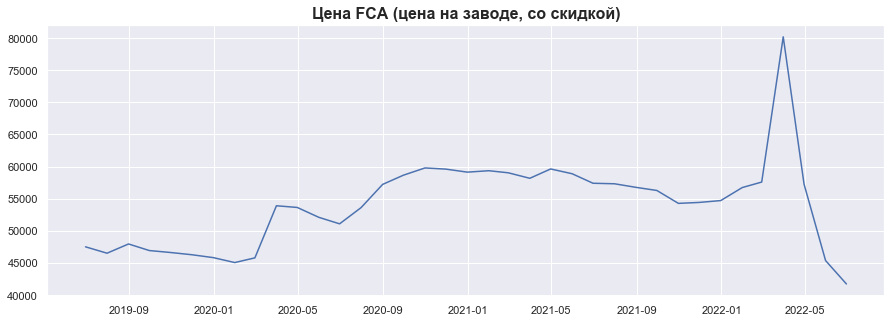

In [31]:
client_proposal_file_path = os.path.join(price_proposals_path, 'price_proposals_RU.xlsx')
with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
    price.to_excel(writer, sheet_name='price_proposal')
        
    # Добавляем график с ценой
    plot_path = 'client_RU.png'
    plt.title('Цена FCA (цена на заводе, со скидкой)', fontsize=16, fontweight='bold')
    plt.plot(price)
    plt.savefig(plot_path)
    worksheet = writer.sheets['price_proposal']
    worksheet.insert_image('C2',plot_path)

if os.path.exists('client_RU.png'):
    os.remove('client_RU.png')
    
# Посмотрим, что у нас получилось   

print('Клиент: client_RU')
print('Скидка:', disc, '%')
print('Цена:', price.head())
plt.show()    

# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


Алгоритм может споткнуться при отсутствии значений, на основе которых нужно вычислить итоговое ценовое предложение, поэтому:

- <font color='red'>**Исключение**</font>: Не указано имя клиента

**Вывод**: Введите имя клиента

- <font color='red'>**Исключение**</font>: Не указана локация клиента / Указана локация клиента, не предусмотренная в скрипте

**Вывод**: Неизвестная локация

- <font color='red'>**Исключение**</font>: Не указан объем поставки

**Вывод**: Введите объем поставки

- <font color='red'>**Исключение**</font>: Не указан способ расчёта цены

**Вывод**: Введите способ расчёта цены


In [32]:
for client, v in customers.items():
    try:
        client_proposal_file_path = os.path.join(price_proposals_path, f'price_proposals_{client}.xlsx')
    except:
        print('Введите имя клиента')
    else:
        disc = 0.0                                  # переменная для скидки

    try:
        if v.get('location') == "EU" or v.get('location') == "CN":
            continue #print('Location is Ok')
    except:
        print('Не указана локация клиента / Указана локация клиента, не предусмотренная в скрипте')
    else:
        if v.get('location') == "EU":
            fl = 0                                 # флаг для определения максимальной скидки
            for k_lim, discount_share in discounts.items():
                
                try:
                    if v.get('volumes') is not None:
                        continue #print('Volumes is Ok')  
                except:
                    print('Введите объем поставки')                    
                else:                    
                    if v.get('volumes') > k_lim:
                        continue
                    else:
                        disc = discount_share
                        fl = 1
                        break
                    if fl == 0:
                        disc = discounts.get(max(discounts.keys()))            

                try:
                    if v.get('comment') is not None:
                        continue #print('Comment is Ok')  
                except:
                    print('Введите способ расчёта цены')                    
                else: 
                    if v.get('comment') == "moving_average":
                        price = round(main_df['MWP_PRICE_EUR_EU_MA'] - main_df['MWP_PRICE_EUR_EU_MA'] * disc, 0)
                        print('Клиент:', client)
                        print('Скидка:', disc, '%')
                        print('Цена:', price[-1], 'euro')
                        print('')
                    elif v.get('comment') == "monthly":
                        price = round(main_df['MWP_PRICE_EUR_EU'] - main_df['MWP_PRICE_EUR_EU'] * disc, 0)            
                        print('Клиент:', client)
                        print('Скидка:', disc, '%')
                        print('Цена:', price[-1], 'euro')
                        print('')

                    elif v.get('location') == 'CN':
                        fl = 0
                        for k_lim, discount_share in discounts.items():
                            if v.get('volumes') > k_lim:
                                continue
                            else:
                                disc = discount_share
                                fl = 1
                                break
                        if fl == 0 :
                            disc = discounts.get(max(discounts.keys()))                    

                        if v.get('comment') == "moving_average":
                            price = round(main_df['MWP_PRICE_USD_CN_MA'] - main_df['MWP_PRICE_USD_CN_MA'] * disc, 0)
                            print('Клиент:', client)
                            print('Скидка:', disc, '%')
                            print('Цена:', price[-1], 'dollar')
                            print('')  
                        elif v.get('comment') == "monthly":
                            price = round(main_df['MWP_PRICE_USD_CN'] - main_df['MWP_PRICE_USD_CN'] * disc, 0) 
                            print('Клиент:', client)
                            print('Скидка:', disc, '%')
                            print('Цена:', price[-1], 'dollar')
                            print('')             

                
                # сохраним информацию в excel-файл, каждого клиента - на отдельном листе
            with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
                price.to_excel(writer, sheet_name='price_proposal')

                # Добавляем график с ценой
                plot_path = f'{client}_wbp.png'
                plt.title('Цена DDP (цена с доставкой)', fontsize=16, fontweight='bold')
                plt.plot(price)
                plt.savefig(plot_path)
                plt.close()
            #    plt.show()
                worksheet = writer.sheets['price_proposal']
                worksheet.insert_image('C2',plot_path)
        
for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

*Тут я, видимо, запуталась с исключениями, т.к. ничего не выводит.*

# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

Сохраняем наш скрипт с расчётом цен в модуль

In [33]:
%%writefile price_proposal_calculation_mod.py

import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import os
from pylab import rcParams
from datetime import datetime


def calculate_price_proposal():
    seaborn.set()

    # Затраты на производство
    PRODUCTION_COST = 400  # (EUR)

    # Расходы на логистику
    EU_LOGISTIC_COST_EUR = 30  # в Европу в евро
    CN_LOGISTIC_COST_USD = 130  # в Китай в долларах

    costs = {
        'PRODUCTION_COST': PRODUCTION_COST,
        'EU_LOGISTIC_COST_EUR': EU_LOGISTIC_COST_EUR,
        'CN_LOGISTIC_COST_USD': CN_LOGISTIC_COST_USD,
    }

    # Справочная информация по клиентам (объемы, локации, комментарии)
    customers = {
        'Monty': {
            'location': 'EU',
            'volumes': 350,
            'comment': 'moving_average'
                    },

        'Triangle': {
            'location': 'CN',
            'volumes': 30,
            'comment': 'monthly'
                    },
        'Stone': {
            'location': 'EU',
            'volumes': 150,
            'comment': 'moving_average'
                    },
        'Poly': {
            'location': 'EU',
            'volumes': 70,
            'comment': 'monthly'
                    }
                }
    
    # Скидки
    discounts = {100: 0.01, # 1%
                 300: 0.05, # 5%
                 301: 0.1}  #10%
    #
    price_proposals_path = 'price_proposals_client'

    # подгружаем котировки курсы
    print("Подгружаем котировки и курсы")
    df_dict = {}
    for ticker in tqdm(['CL=F', 'USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
        df = yf.download(ticker, progress=False)
        df = df.Close.copy()
        df = df.resample('M').mean()
        df_dict[ticker] = df  
        
    # рассчитываем цены
    print("Рассчитываем цены")
    
    # скачаем котировки натурального каучука с сайта Малайзийской Rubber Board https://www.lgm.gov.my
    year = '2022'
    month = '06'
    url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
    res = requests.get(url)
    rj = res.json()
    df = pd.json_normalize(rj)

    # приведём столбцы с датой и ценами к нужным нам типам данных
    df['date'] = pd.to_datetime(df['date'])
    df['us'] = df['us'].astype(float)

    # cинтетический каучук будет заменой натуральному с грейдом SMR 20, сформируем датафрэйм с данными по нему
    df_smr_20 = df[df['grade'] == 'SMR 20']
    df_smr_20.set_index('date', inplace=True)

    # переместим даты в индекс и рассчитаем среднемесячную цену в долларах к последней дате
    mes = round(df_smr_20[['us']].resample('M').mean(), 2)

    # мы получили среднемесячную цену в us за килограмм, сохраним в отдельную переменную
    PRICE_SMR_20 = mes.iloc[0]['us']
    PRICE_SMR_20    
    
    main_df = pd.concat(df_dict.values(), axis=1)
    main_df.columns = ['CRUDE_OIL_USD', 'USDRUB', 'EURUSD', 'EURRUB']
    
    # ограничим данные последними 4 годами:
    main_df = main_df.loc['2019-06-30':'2022-06-30'].copy()
    
    # формулу цены FCA (цена на заводе) синтетического каучука в долларах и евро
    main_df['MWP_PRICE_EUR'] = (PRICE_SMR_20 * (1/main_df['EURUSD'])) * 2 + costs.get('PRODUCTION_COST')
    main_df['MWP_PRICE_USD'] = (PRICE_SMR_20 * main_df['EURUSD']) * 2 + costs.get('PRODUCTION_COST') * main_df['EURUSD']

    # добавим к цене FCA (цена на заводе) затраты на логистику с учётом территории клиента
    main_df['MWP_PRICE_EUR_EU'] = main_df['MWP_PRICE_EUR'] + costs.get('EU_LOGISTIC_COST_EUR')
    main_df['MWP_PRICE_USD_CN'] = main_df['MWP_PRICE_USD'] + costs.get('CN_LOGISTIC_COST_USD')
    
    # добавим столбец с со средними ценами за три месяца:
    main_df['MWP_PRICE_EUR_EU_MA'] = main_df['MWP_PRICE_EUR_EU'].rolling(window=3).mean()
    main_df['MWP_PRICE_USD_CN_MA'] = main_df['MWP_PRICE_USD_CN'].rolling(window=3).mean()


    # создаем отдельный файл с расчётом цены для каждого из клиентов         

    rcParams['figure.figsize'] = 15,7

    print("Готовим отдельный файл для клиентов")
    for client, v in customers.items():

        # Создаем директорию и путь к файлу
        client_proposal_file_path = os.path.join(price_proposals_path, f'price_proposals_{client}.xlsx')
        if not os.path.exists(client_proposal_file_path ):
            os.makedirs(client_proposal_file_path)

        calculation_date = datetime.today().date().strftime(format="%d%m%Y")
        client_price_file_path = os.path.join(client_proposal_file_path, f'{client}_mwp_price_{calculation_date}.xlsx')

        disc = 0.0  # переменная для скидки
        if v.get('location') == "EU":
            fl = 0                                 # флаг для определения максимальной скидки
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0:
                disc = discounts.get(max(discounts.keys()))
              
            if v.get('comment') == "moving_average":
                price = round(main_df['MWP_PRICE_EUR_EU_MA'] - main_df['MWP_PRICE_EUR_EU_MA'] * disc, 0)
            elif v.get('comment') == "monthly":
                price = round(main_df['MWP_PRICE_EUR_EU'] - main_df['MWP_PRICE_EUR_EU'] * disc, 0)                  
                 
        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0:
                disc = discounts.get(max(discounts.keys()))
            
            if v.get('comment') == "moving_average":
                price = round(main_df['MWP_PRICE_USD_CN_MA'] - main_df['MWP_PRICE_USD_CN_MA'] * disc, 0)
            elif v.get('comment') == "monthly":
                price = round(main_df['MWP_PRICE_USD_CN'] - main_df['MWP_PRICE_USD_CN'] * disc, 0)
         
            
            # сохраним информацию в excel-файл, каждого клиента - на отдельном листе            
        with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
            price.to_excel(writer, sheet_name='price_proposal')

            # добавим график с ценой
            plot_path = f'{client}_wbp.png'
            plt.title('Цена DDP (цена с доставкой)', fontsize=16, fontweight='bold')
            plt.plot(price)
            plt.savefig(plot_path)
            plt.close()

            worksheet = writer.sheets['price_proposal']
            worksheet.insert_image('C2',plot_path)

        print(f"{client} готов")

    print("Удаляем ненужные файлы")
    for k, v in customers.items():
        if os.path.exists(f"{k}_wbp.png"):
            os.remove(f"{k}_wbp.png")

    print("Работа завершена!")

if __name__ == "__main__":
    calculate_prices()

Overwriting price_proposal_calculation_mod.py


Импортируем модуль

In [34]:
from price_proposal_calculation_mod import calculate_price_proposal

Проверяем, что всё корректно

In [35]:
calculate_price_proposal()

Подгружаем котировки и курсы



Рассчитываем цены
Готовим отдельный файл для клиентов
Monty готов
Triangle готов
Stone готов
Poly готов
Удаляем ненужные файлы
Работа завершена!


# Задание 6. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

* Создайте отдельный пакет, который можно устанавливать с помощью pip 
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в репозиторий

In [36]:
# !pip install yourpackage
# import yourpackage

*Этот раздел ещё не разобрали.*